In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import math

In [2]:
def TFIM_multiply(psi, phi, N, J, Gamma):
    dim = 2 ** N
    for state in range(dim):
        jtotal = 0
        for site in range(N - 1):
            jtotal += J if ((state >> site) ^ (state >> (site + 1))) & 1 else -J 
        jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J
        phi[state] = jtotal * psi[state]
    
    for state in range(dim):
        for site in range(N):
            flipped_state = state ^ (1 << site)
            phi[flipped_state] -= Gamma*psi[state]

def TFIM_expectation(psi, N, J, Gamma):
    dim = 2 ** N
    phi = np.zeros(dim, dtype=np.complex128)
    psi = np.array(psi)
    bra_psi = psi.reshape((1, -1)).conj()
    TFIM_multiply(psi, phi, N, J, Gamma)
    return (bra_psi @ phi.reshape((-1, 1)))[0][0]

def generate_state(state_num, N):
    x = np.zeros((N, 1))
    for n in range(N):
        x[n][0] = (state_num >> n) & 1
    return x

def sigmoid(x):
    return np.array([math.copysign(1, n[0]) * 1 if abs(n[0]) > 10 else 1/(1 + np.exp(-n[0])) for n in x]).reshape((-1, 1))

def compute_NN(weights, layers, N, J, Gamma):
    # weights as 1D array, first N * N numbers are first layer weights
    # next N numbers are first layer biases, next 2 * N numbers are second
    # layer weights, next 2 numbers are second layer biases.
    results = []
    dim = 2 ** N

    weights = np.array(weights)
    weight_arr = []
    bias_arr = []
    total = 0
    for i in range(1, len(layers)):
        weight_arr.append(weights[total:(total + layers[i] * layers[i - 1])].reshape((layers[i], layers[i - 1])))
        total += layers[i] * layers[i - 1]
        bias_arr.append(weights[total:(total + layers[i])].reshape((-1, 1)))
        total += layers[i]
    for state in range(dim):
        vector = generate_state(state, N)
        for i in range(len(weight_arr)):
            vector = sigmoid(weight_arr[i] @ vector + bias_arr[i])
        results.append(vector[0][0] + vector[1][0] * 1.j)
    
    mag = sum(abs(n) ** 2 for n in results)

    expect = TFIM_expectation(results, N, J, Gamma) / mag
    return expect.real 

def number_weights(layers):
    total = 0
    for i in range(1, len(layers)):
        total += layers[i] * layers[i - 1] + layers[i]
    return total

def TFIM_hamiltonian(n, J, gamma):
    # uses ring shape
    id = qt.qeye(2)
    z = qt.sigmaz()
    x = qt.sigmax()
    sxi = []
    szi = []
    for i in range(n):
        sxi.append(qt.tensor([id] * i + [x] + [id] * (n - i - 1)))
        szi.append(qt.tensor([id] * i + [z] + [id] * (n - i - 1)))
    return -J * sum(szi[i] * szi[i + 1] for i in range(n - 1)) - J * szi[n - 1] * szi[0] - gamma * sum(sxi[i] for i in range(n))

In [3]:
evec_data = []
eval_data = []
J = 1
gamma_vals = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
for n in range(2, 6):
    fidelities = []
    evals = []
    for Gamma in gamma_vals:
        # optimize neural network
        layers = [n, 2 * n, 2]
        num_weights = number_weights(layers)
        init_weights = np.ones(num_weights) * -1
        # init_weights = np.random.normal(size = num_weights)
        res = so.minimize(lambda w : compute_NN(w, layers, n, J, Gamma), init_weights, method = 'Powell')

        # find groud state
        weights = res.x

        results = []
        dim = 2 ** n

        weights = np.array(weights)
        weight_arr = []
        bias_arr = []
        total = 0
        for i in range(1, len(layers)):
            weight_arr.append(weights[total:(total + layers[i] * layers[i - 1])].reshape((layers[i], layers[i - 1])))
            total += layers[i] * layers[i - 1]
            bias_arr.append(weights[total:(total + layers[i])].reshape((-1, 1)))
            total += layers[i]
        for state in range(dim):
            vector = generate_state(state, n)
            for i in range(len(weight_arr)):
                vector = sigmoid(weight_arr[i] @ vector + bias_arr[i])
            results.append(vector[0][0] + vector[1][0] * 1.j)

        mag = sum(abs(n) ** 2 for n in results)

        gs = np.array(results) / np.sqrt(mag)
        
        # confirmation
        h = TFIM_hamiltonian(n, J, Gamma)

        fidelities.append(qt.fidelity(qt.Qobj([abs(s) for s in gs]), h.eigenstates()[1][0]))
        evals.append(res.fun)
    evec_data.append(fidelities)
    eval_data.append(evals)

In [4]:
true_evals = []
for n in range(2, 6):
    x = []
    for Gamma in gamma_vals:
        h = TFIM_hamiltonian(n, J, Gamma)
        x.append(h.eigenstates()[0][0])
    true_evals.append(x)

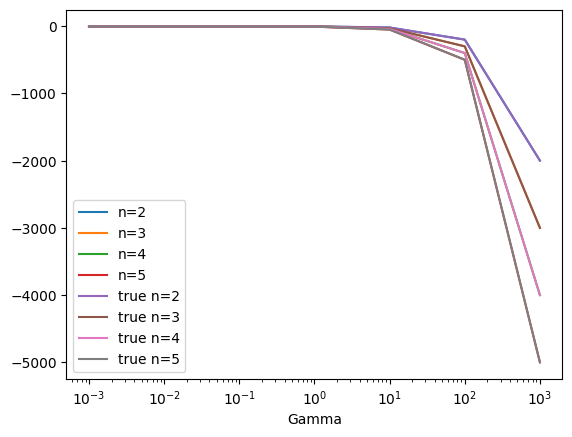

In [6]:
for i in range(len(eval_data)):
    plt.plot(gamma_vals, eval_data[i], label=f'n={i + 2}')
for i in range(len(true_evals)):
    plt.plot(gamma_vals, true_evals[i], label = f'true n={i + 2}')
plt.xlabel('Gamma')
plt.ylabel('')
plt.legend(loc = 'best')
plt.xscale('log')
# plt.yscale('log')
plt.show()

In [7]:
np.abs(np.array(eval_data) - np.array(true_evals))

array([[1.01382059e-06, 1.00010934e-04, 4.95177688e-03, 1.13789275e-06,
        5.74124441e-05, 5.40987230e-07, 8.80016137e-06],
       [2.55030819e-06, 8.14049401e-05, 8.45934321e-04, 4.54349744e-03,
        1.14807868e-02, 7.53754569e-03, 7.50375038e-04],
       [1.48826326e-03, 2.68176214e-04, 7.69568514e-04, 3.65841265e-04,
        2.51886375e-02, 1.00003750e-02, 1.00000037e-03],
       [1.01238176e-04, 4.66913524e-03, 1.51478618e-03, 4.81518756e-03,
        1.07760698e-02, 6.86944402e-03, 1.25000007e-03]])

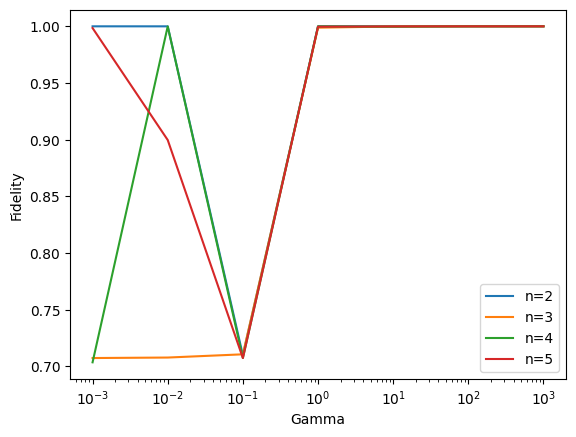

In [8]:
for i in range(len(evec_data)):
    plt.plot(gamma_vals, evec_data[i], label=f'n={i + 2}')
plt.xlabel('Gamma')
plt.ylabel('Fidelity')
plt.legend(loc = 'best')
plt.xscale('log')
# plt.yscale('log')
plt.show()